In [6]:

%%capture
!pip install mediapipe

In [7]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
     

In [8]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [10]:
from zipfile import ZipFile
# from zipfile import BadZipFile
# specifying the zip file name
file_name = "/content/AFLW2000-3D.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
AFLW2000/                                      2016-03-29 22:52:46            0
AFLW2000/Code/                                 2016-03-29 23:02:26            0
AFLW2000/Code/DrawSolidHead.m                  2016-03-29 22:52:42         1457
AFLW2000/Code/DrawTextureHead.m                2016-03-29 22:52:42          469
AFLW2000/Code/main_show_without_BFM.m          2016-03-29 23:04:16          291
AFLW2000/Code/main_show_with_BFM.m             2016-03-29 23:02:04         2437
AFLW2000/Code/Mex/                             2016-03-29 22:52:42            0
AFLW2000/Code/Mex/compile.m                    2016-03-29 22:52:42           36
AFLW2000/Code/Mex/Tnorm_Vnorm.h                2016-03-29 22:52:42          456
AFLW2000/Code/Mex/Tnorm_VnormC.cpp             2016-03-29 22:52:42          496
AFLW2000/Code/Mex/Tnorm_VnormC.mexw64          2016-03-29 22:52:42         7168
AFLW2000/Code/ModelGeneration/          

In [11]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

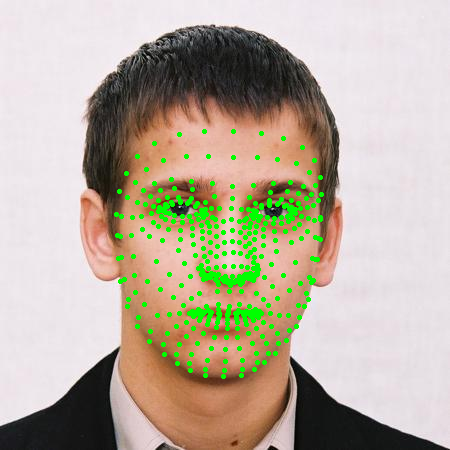

In [12]:
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)
     

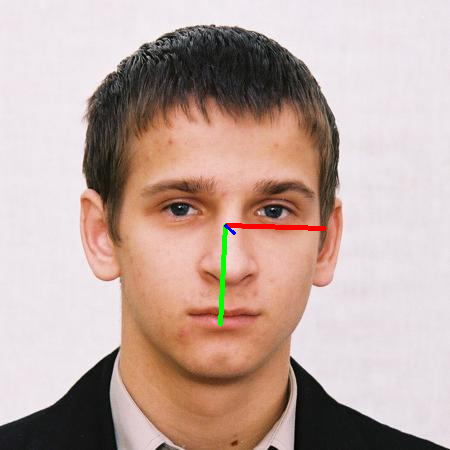

In [13]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [14]:
def extract_features(img, face_mesh, mat=None):
    NOSE = 1
    FOREHEAD = 10
    LEFT_EYE = 33
    MOUTH_LEFT = 61
    CHIN = 199
    RIGHT_EYE = 263
    MOUTH_RIGHT = 291


    result = face_mesh.process(img)
    face_features = []

    if result.multi_face_landmarks != None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in [FOREHEAD, NOSE, MOUTH_LEFT, MOUTH_RIGHT, CHIN, LEFT_EYE, RIGHT_EYE]:
                    face_features.append(lm.x)
                    face_features.append(lm.y)
    else:
        face_features.extend([None] * 14)
    
    if mat:
        pose_angles = mat['Pose_Para'][0][:3]
        face_features.extend(pose_angles)
        
    return face_features

In [15]:
import matplotlib.pyplot as plt

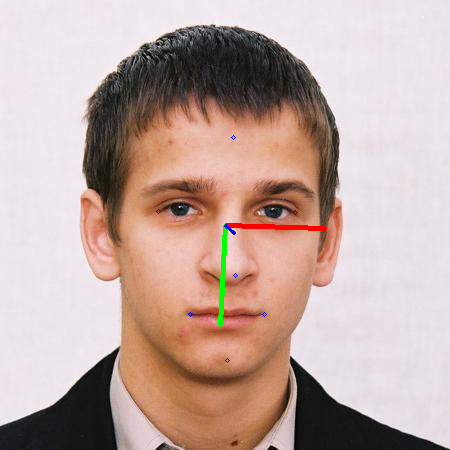

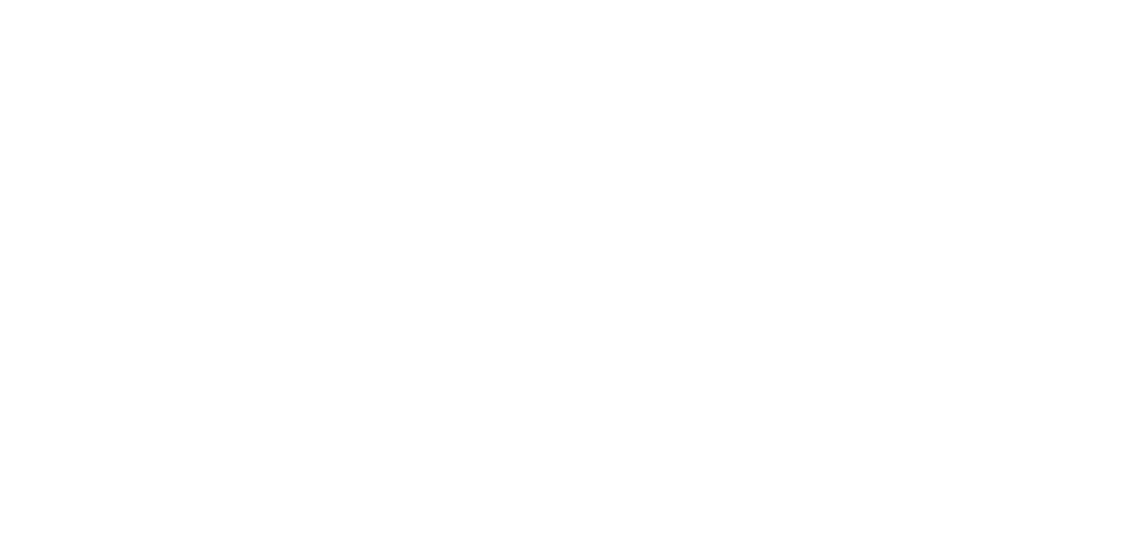

In [16]:
face_mesh = mediapipe.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
s = extract_features(image, face_mesh)
annot_img = image.copy()
img_h, img_w, img_c = image.shape
for i in range(len(s)//2):
        cv2.circle(annot_img, center=[int(s[i*2]*img_w), int(s[i*2+1]*img_h)], radius=2, color=(255, 0, 0))
plt.figure(figsize=(20, 10))
plt.axis('off')
# plt.imshow(annot_img);
cv2_imshow(annot_img)

In [17]:
images_paths = glob.glob('./AFLW2000/*.jpg')
img_info_paths = glob.glob('./AFLW2000/*.mat')

In [18]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)
cols.extend(['pitch', 'yaw', 'roll'])

In [19]:
face_mesh = mediapipe.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
poses = []

for img_idx, img_path in enumerate(images_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mat = sio.loadmat(img_info_paths[img_idx])
    face_features = extract_features(img, face_mesh, mat)
    poses.append(face_features)
    if img_idx % 100 == 0:
        print('Extracted images: ', img_idx)

poses_df = pd.DataFrame(poses, columns=cols)

Extracted images:  0
Extracted images:  100
Extracted images:  200
Extracted images:  300
Extracted images:  400
Extracted images:  500
Extracted images:  600
Extracted images:  700
Extracted images:  800
Extracted images:  900
Extracted images:  1000
Extracted images:  1100
Extracted images:  1200
Extracted images:  1300
Extracted images:  1400
Extracted images:  1500
Extracted images:  1600
Extracted images:  1700
Extracted images:  1800
Extracted images:  1900


In [20]:
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.508065,0.618530,0.616757,0.283798,0.378097,0.401824,0.372199,0.663082,0.422852,0.808474,0.707475,0.522665,0.543664,0.726624,0.758220,1.191774,0.751087
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004769,-0.022654,-0.001833
2,0.539672,0.612833,0.409729,0.320937,0.319459,0.537305,0.444169,0.713631,0.600985,0.798996,0.609518,0.418110,0.641840,0.632342,-0.461113,-1.372663,0.508271
3,0.479451,0.604121,0.466947,0.329683,0.365209,0.517700,0.440307,0.682836,0.524996,0.784532,0.636129,0.474694,0.599474,0.660368,0.072609,0.131508,0.017875
4,0.562461,0.582324,0.501192,0.336663,0.368117,0.502097,0.462611,0.687573,0.546574,0.764271,0.606819,0.471318,0.586158,0.662821,2.316127,1.430669,2.337543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.620673,0.585285,0.504539,0.331914,0.405458,0.509754,0.486567,0.696190,0.620810,0.814558,0.615169,0.488876,0.640025,0.680426,0.588442,-1.040858,-0.374304
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.072596,0.061031,-0.048805
1997,0.448416,0.589094,0.579442,0.387159,0.458044,0.465105,0.424415,0.636657,0.434892,0.723104,0.650495,0.562765,0.519936,0.691901,-0.263568,1.152658,-0.426291
1998,0.544581,0.595692,0.570166,0.344280,0.423214,0.458189,0.455642,0.655821,0.505559,0.746889,0.647185,0.514486,0.584993,0.676148,-0.397413,-0.115143,-0.376447


In [21]:
poses_df.shape

(2000, 17)

In [23]:
# poses_df.to_csv('./poses.csv', index=False)
data_path = '/content/pose.csv'  #the path where you downloaded the data
poses_df = pd.read_csv(data_path)

In [24]:
poses_df = poses_df.dropna(axis=0)
poses_df.shape

(1792, 17)

In [25]:
def normalize(poses_df):
    normalized_df = poses_df.copy()
    
    for dim in ['x', 'y']:
        # Centerning around the nose 
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = poses_df[feature] - poses_df['nose_'+dim]
        
        
        # Scaling
        diff = normalized_df['mouth_right_'+dim] - normalized_df['left_eye_'+dim]
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = normalized_df[feature] / diff
    
    return normalized_df

In [26]:
poses_df = normalize(poses_df)
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.0,0.0,0.145389,-1.315685,-0.612647,-0.757945,-0.389327,0.157636,-0.035876,0.643461,0.821789,-0.634208,0.387353,0.242055,-0.399231,0.018227,0.085676
1,0.0,0.0,0.643168,-1.238742,0.061645,-0.584067,0.174874,0.306017,0.400586,0.764764,1.780222,-0.463914,1.061645,0.415933,0.470065,1.189533,0.300959
2,0.0,0.0,-0.012524,-1.450241,-0.134608,-0.661405,0.217967,0.362334,0.524888,0.861074,0.886842,-0.706921,0.865392,0.338595,-0.184650,0.881137,-0.236852
3,0.0,0.0,-0.239980,-1.951528,-0.454436,-0.874364,-0.017618,0.357641,0.334972,0.924901,0.547998,-1.273491,0.545564,0.125636,-0.175379,0.299208,-0.373374
4,0.0,0.0,0.206458,-1.236728,0.227247,-0.580952,0.552568,0.414430,0.860054,0.827818,1.380055,-0.666052,1.227247,0.419048,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.0,0.0,-0.069582,-1.516075,-0.835918,-0.675221,-0.497313,0.355848,-0.156862,0.798616,0.459186,-0.690928,0.164082,0.324779,-0.306358,-0.283822,0.038554
1992,0.0,0.0,-0.034515,-1.424327,-0.886287,-0.717177,-0.613809,0.292342,-0.229223,0.765727,0.467706,-0.711614,0.113713,0.282823,-0.367547,-0.429723,0.122791
1994,0.0,0.0,0.424978,-1.002710,-0.711851,-0.594513,-0.683567,0.258108,-0.404571,0.692207,0.930189,-0.319230,0.288149,0.405487,-0.156035,0.567114,-0.108536
1995,0.0,0.0,0.170664,-1.239908,-0.620394,-0.700198,-0.348568,0.218915,-0.016775,0.625044,0.910883,-0.509458,0.379606,0.299802,-0.197102,-0.070430,0.105118


In [27]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(poses_df, test_size=0.2, random_state=42)


X_train = train_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_train = train_df[['pitch', 'yaw', 'roll']]

X_val = val_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_val = val_df[['pitch', 'yaw', 'roll']]
print(X_train.shape, y_train.shape)

(1433, 14) (1433, 3)


In [28]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from sklearn.metrics import mean_squared_error

param_grid = {
    'estimator__kernel': ['linear', 'poly', 'rbf'],
    'estimator__C': scipy.stats.expon(scale=5),
    'estimator__degree': np.arange(2, 6),
    'estimator__coef0': np.arange(0, 6),
    'estimator__gamma': scipy.stats.expon(scale=.1),
    'estimator__epsilon': scipy.stats.expon(scale=.1)
}

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
random_search = RandomizedSearchCV(multi_out_svr, param_grid, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
svr_model = random_search.best_estimator_
print('best parameters: ', random_search.best_params_)
print('train_rmse: ', np.sqrt(-random_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, svr_model.predict(X_val))))

best parameters:  {'estimator__C': 2.3463404498842957, 'estimator__coef0': 4, 'estimator__degree': 4, 'estimator__epsilon': 0.13167456935454494, 'estimator__gamma': 0.09129425537759533, 'estimator__kernel': 'rbf'}
train_rmse:  0.22580119825259934
validation_rmse:  0.1884249528604136


In [29]:
#decision tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'estimator__max_depth': np.arange(2, 10),
    'estimator__min_samples_split': np.logspace(1, 7, 7, base=2).astype(int),
    'estimator__min_samples_leaf': np.logspace(0, 6, 7, base=2).astype(int),
    'estimator__max_features': np.arange(4, 15),
    'estimator__ccp_alpha': scipy.stats.expon(scale=.1),
}

reg_tree = DecisionTreeRegressor(random_state=42)
multi_out_tree = MultiOutputRegressor(reg_tree)

random_search = RandomizedSearchCV(multi_out_tree, param_grid, scoring='neg_mean_squared_error', n_iter=40)
random_search.fit(X_train, y_train)
tree_model = random_search.best_estimator_

print('best parameters: ', random_search.best_params_)
print('train_rmse: ', np.sqrt(-random_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, tree_model.predict(X_val))))

best parameters:  {'estimator__ccp_alpha': 0.0012342680211354022, 'estimator__max_depth': 7, 'estimator__max_features': 12, 'estimator__min_samples_leaf': 16, 'estimator__min_samples_split': 8}
train_rmse:  0.25197279103887543
validation_rmse:  0.21969888536631793


i will use SVR

In [30]:
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.grid_search import GridSearchCV
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV

#randomized search cause grid search was taking forever
param_grid = {
    'estimator__kernel': ['rbf'],
    'estimator__C': np.arange(0.6, 0.75, 0.01),
    'estimator__gamma': np.arange(0.09, 0.1, 0.001),
    'estimator__epsilon': np.arange(0.07, 0.08, 0.001)
}

svr = SVR()
multi_out_svr = MultiOutputRegressor(svr)
# clf = RandomizedSearchCV(multi_out_svr, param_grid)
# clf.fit(X_train, y_train)
grid_search = RandomizedSearchCV(multi_out_svr, param_grid, scoring='neg_mean_squared_error').fit(X_train, y_train)
model = grid_search.best_estimator_
grid_search.fit(X_train, y_train)
print('best parameters: ', grid_search.best_params_)
print('train_rmse: ', np.sqrt(-grid_search.best_score_))
print('validation_rmse: ', np.sqrt(mean_squared_error(y_val, model.predict(X_val))))


best parameters:  {'estimator__kernel': 'rbf', 'estimator__gamma': 0.096, 'estimator__epsilon': 0.07300000000000001, 'estimator__C': 0.7400000000000001}
train_rmse:  0.22781035468742303
validation_rmse:  0.189490258003162


In [31]:
import pickle

In [32]:
pickle.dump(model, open('./model.pkl', 'wb'))

In [33]:
model = pickle.load(open('./model.pkl', 'rb'))
model

MultiOutputRegressor(estimator=SVR(C=0.7200000000000001,
                                   epsilon=0.07400000000000001, gamma=0.097))

In [34]:
import glob

In [35]:
def draw_axes(img, pitch, yaw, roll, tx, ty, size=50):
    yaw = -yaw
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)
    axes_points = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]
    ], dtype=np.float64)
    axes_points = rotation_matrix @ axes_points
    axes_points = (axes_points[:2, :] * size).astype(int)
    axes_points[0, :] = axes_points[0, :] + tx
    axes_points[1, :] = axes_points[1, :] + ty
    
    new_img = img.copy()
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 0].ravel()), (255, 0, 0), 3)    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 1].ravel()), (0, 255, 0), 3)    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 2].ravel()), (0, 0, 255), 3)
    return new_img

Image shape:  (450, 450, 3)
targets:  [0.5133038 0.6603237 0.0738679]


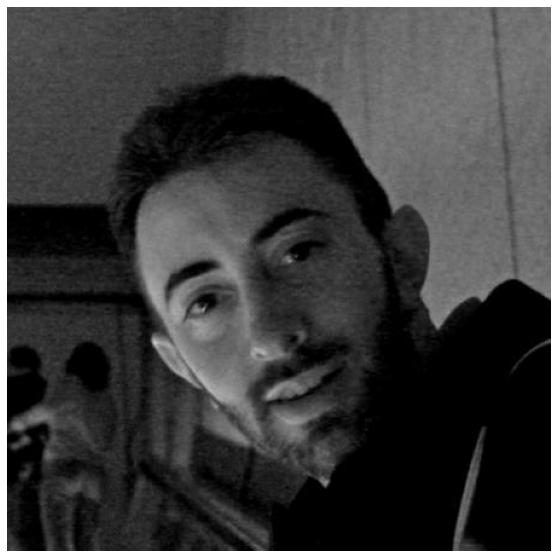

In [36]:
DEMO_IMG_NUMBER = 11
images_paths = glob.glob('./AFLW2000/*.jpg')
img = cv2.imread(images_paths[DEMO_IMG_NUMBER])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img);

img_info_paths = glob.glob('./AFLW2000/*.mat')
mat = scipy.io.loadmat(img_info_paths[DEMO_IMG_NUMBER])
print('targets: ', mat['Pose_Para'][0][:3].ravel())  

In [51]:
def extract_features1(img, face_mesh):
    NOSE = 1
    FOREHEAD = 10
    LEFT_EYE = 33
    MOUTH_LEFT = 61
    CHIN = 199
    RIGHT_EYE = 263
    MOUTH_RIGHT = 291

    result = face_mesh.process(img)
    face_features = []
    
    if result.multi_face_landmarks != None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in [FOREHEAD, NOSE, MOUTH_LEFT, MOUTH_RIGHT, CHIN, LEFT_EYE, RIGHT_EYE]:
                    face_features.append(lm.x)
                    face_features.append(lm.y)

    return face_features

In [55]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)

In [49]:
def normalize(poses_df):
    normalized_df = poses_df.copy()
    
    for dim in ['x', 'y']:
        # Centerning around the nose 
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = poses_df[feature] - poses_df['nose_'+dim]
        
        
        # Scaling
        diff = normalized_df['mouth_right_'+dim] - normalized_df['left_eye_'+dim]
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = normalized_df[feature] / diff
    
    return normalized_df

In [56]:
face_mesh = mediapipe.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
face_features = extract_features1(img, face_mesh)
print(len(face_features))
if face_features: 
  face_features_df = pd.DataFrame([face_features],columns=cols)
  face_features_normalized = normalize(face_features_df)
  pitch_pred, yaw_pred, roll_pred = model.predict(face_features_normalized).ravel()
  print('predictions: ', pitch_pred, yaw_pred, roll_pred)

14
predictions:  -0.23947589158213722 0.034607451612098106 -0.5427384935095015


In [57]:
face_features_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y
0,0.498638,0.629867,0.372525,0.361743,0.330636,0.557001,0.474706,0.71652,0.587455,0.765796,0.574446,0.433579,0.618793,0.644398


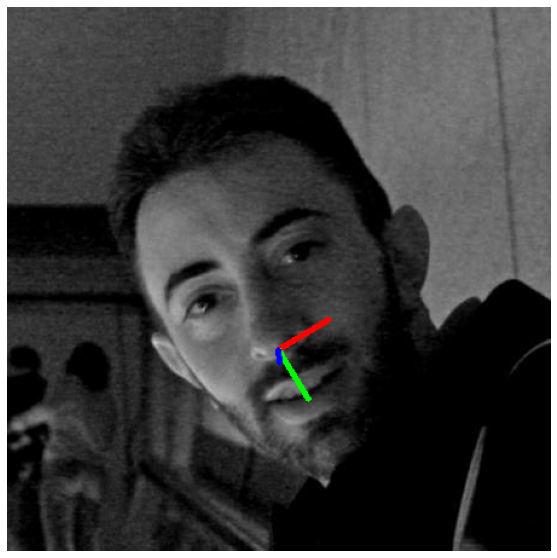

In [58]:
img_h, img_w, img_c = img.shape
nose_x = face_features_df['nose_x'].values * img_w
nose_y = face_features_df['nose_y'].values * img_h

new_img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(new_img);

In [79]:
from google.colab.patches import cv2_imshow

face_mesh = mediapipe.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture(r'/content/hend.mp4')  # From Camera
video_width=int(cap.get(3))
video_height=int(cap.get(4))
size=(video_width,video_height)
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc('M','J','P','G') # codec for the output video

out = cv2.VideoWriter(r'output.mp4', fourcc, 20, size) # output video path, codec, FPS, and frame size

while(cap.isOpened()):

    # Take each frame
    ret, img = cap.read()
    if ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.flip(img, 1)
        img_h, img_w, img_c = img.shape
        text = ''
        
        
        face_features = extract_features(img, face_mesh)
        if len(face_features):
            #put it in dataframe
            face_features_df = pd.DataFrame([face_features], columns=cols)
            #normalize
            face_features_normalized = normalize(face_features_df)
            pitch_pred, yaw_pred, roll_pred = model.predict(face_features_normalized).ravel()
            nose_x = face_features_df['nose_x'].values * img_w
            nose_y = face_features_df['nose_y'].values * img_h
            img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
                        
            if pitch_pred > 0.3:
                text = 'Top'
                if yaw_pred > 0.3:
                    text = 'Top Left'
                elif yaw_pred < -0.3:
                    text = 'Top Right'
            elif pitch_pred < -0.3:
                text = 'Bottom'
                if yaw_pred > 0.3:
                    text = 'Bottom Left'
                elif yaw_pred < -0.3:
                    text = 'Bottom Right'
            elif yaw_pred > 0.3:
                text = 'Left'
            elif yaw_pred < -0.3:
                text = 'Right'
            else:
                text = 'Forward'
                
        cv2.putText(img, text, (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(img) # write the frame to the output video
        # cv2_imshow(img)
        k = cv2.waitKey(1) & 0xFF
        if k == ord("q"):
            break
    else:
        break

# Release everything if job is finished
out.release()
cv2.destroyAllWindows()